<CENTER><img src="images/logos.png" style="width:50%"></CENTER>

<CENTER><h1>Searching for the Higgs boson </h1></CENTER>


Below are some Feyman diagrams of ways the Higgs boson can be produced according to the Standard Model:

<br>

<CENTER><img src="https://cds.cern.ch/record/2243593/files/Figures_FeynmanHprod.png" style="width:50%"></CENTER>

Just as the Higgs can be produced in several ways, the Higgs can also decay in a number of ways or 'channels'. In this excercise, we will be searching for the Higgs in two different decay channels.

---

### Before we begin:

- Some of the datafiles used in this notebook have millions of events - Don't be surpised if running certain event loops takes up to 10 mins (or longer)!

- This notebook is designed to give you an idea of how a real physics analysis is set up. Study it carefully to help with your own research!

- The two analyses presented in this notebooks are inspired by the [prompts](http://opendata.atlas.cern/release/2020/documentation/physics/intro.html) on the ATLAS Open Data website. 
    - This is a great place to start for ideas for your own research!

---

<CENTER><h2>Search 1: The H&#8594;&gamma;&gamma; channel</h2></CENTER>

<CENTER><img src="./images/higgsFD.png" style="width:30%"></CENTER>

<br>
  
One of the ways the Higgs can decay is to two photons. We call this channel __H&#8594;&gamma;&gamma;__ ("Higgs to gamma gamma").


Of course, there are other ways two photons can be made in the LHC, but if we look at the entire range of invariant masses of these two photons, we should expect there to be more of them around 125 GeV, the mass of the Higgs ("bump hunting").

### This analysis is inspired by the prompt on the Open Data website [here](http://opendata.atlas.cern/release/2020/documentation/physics/YY.html).

#### Importing the usual libraries

In [1]:
import ROOT
from ROOT import TMath

Welcome to JupyROOT 6.18/04


### 1. Reading in ROOT files
<br>
In the usual way:

1. Open our datafile containing two photon ("diphoton" or $\gamma\gamma$) events 

2. Retrieive the TTree storing the data and 

3. Get the tree entries 

<br>

As always, if you need hints, refer back to the first tutorial `HistogramTutorial`.

#### a) Open Root File

Using `ROOT`, `TFile.Open()` a sample of diphoton data, stored at 

`https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root`

 

In [26]:
f = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root")

#### b) Retrieve TTree

`Get()` the TTree named `mini` from the ROOT file `f`

In [27]:
tree = f.Get("mini")

#### c) Load TTree data

`GetEntries()` of our `tree` to print the number of events in the tree as a check that the data has loaded properly

In [ ]:
tree.GetEntries()

### 2. Preparing histograms
<br>

As in previous examples, before we are ready to fill our histograms we need to:

1. Create a canvas for the histogram to be drawn onto

2. Define the settings of the histograms we intend to draw

#### a) Create canvas

Using `ROOT`, create a `TCanvas` named `"Canvas"` with the title `'cz'` that's sized `800`x`600` pixels

In [ ]:
canvas = ROOT.TCanvas("Canvas","cz",800,600)

#### b) Set up histogram 

Set up a `TH1F` type histogram to be filled with our __diphoton invariant masses__. Name it `h_M_Hyy`, give it the title `Diphoton invariant-mass`, label the x and y axes `Invariant Mass m_{yy} [GeV]` and `events` respectively and divide it in `30` bins between `105` and `160` GeV.

__Hint:__ Remember how we separate names, titles and axis labels in the `TH1F` function?

In [ ]:
#Invariant mass histograms definition
hist = ROOT.TH1F("h_M_Hyy","Diphoton invariant-mass ; Invariant Mass m_{yy} [GeV] ; events",30,105,160)

### 3. Selecting events and filling histograms

Our strategy, for filling our diphoton invariant mass histogram is as follows:

1. Loop through each `event` in our `tree`. We can print out how many events have been processed every 100000 events to keep track of progress.

2. In each event, search for _'good quality photons'_ (more on this later).

3. If there are exactly two qood quality photons, check that they are _'well isolated'_ (again, more later).

4. If the two photons are well-isolated, extract their 4 momentum from the the pT, eta, phi and energy TTree branches, and store in a TLorentz vector. Make sure to convert their transverse momentum (pT) and energy (E) from MeV, as is stored in the TTree, to GeV as will be displayed in the histogram.

5. Add the TLorentz vectors of the two photons together

6. Calculate the invariant mass of our two-photon system

6. Check each photon makes up a minimum fraction of the diphoton system invariant mass

8. Fill the histogram with the invariant mass of our two-photon system

__NOTE:__ To simplify our code, we will be writing some custom __functions__ to perform each of the above operations.

#### 1) Loop tracker

In [2]:
def trackProgress(n,m):
    """
    Function which prints the event loop progress every m events 
    
    Parameters
    ----------
    n : Number of events processed so far
    
    m : Printout event interval
    
    """
    if n == 0:
        print("Event loop tracker")
        print("------------------")
    
    if(n%m==0):
        print("%d events processed" % n)

#### 2) Photon quality

In [3]:
def locateGoodPhotons(tree):
    """
    Function which returns the index of photons in the event which pass our quality requirements.
    These are:
        - Event passes photon trigger
        - Photon is identified as such, passing 'Tight' requirements 
            - This means we are very sure our photon is indeed a photon, but we might lose some photons that are 
              less obvious in the process. The opposite of this is the 'Loose' requirement, where we are less
              sure that our photon is a photon, but we are less likely to miss real ones .
        - Photon has pT > 25 GeV (or 25000 MeV)
        - Photon is in the 'central' region of ATLAS i.e. it has |eta| < 2.37
        - Photon does not fall in the 'transition region' between ATLAS's inner detector barrell
          and ECal endcap i.e. 1.37 <= |eta| <= 1.52
          
    Parameters
    ----------
    tree : TTree entry for this event
    
    """
    
    ## Checking the event passes the photon trigger
    if(tree.trigP):
        
        #Initialise (set up) the variables we want to return
        goodphoton_index = [] #Indices (position in list of event's photons) of our good photons
            
        ##Loop through all the photons in the event
        for j in range(0,tree.photon_n):
            
            ##Check photon ID
            if(tree.photon_isTightID[j]):
                
                #Check photon has a large enough pT
                if (j==0 and tree.photon_pt[j] > 35000) or (j==1 and tree.photon_pt[j] > 25000):
                    
                    #Check photon eta is in the 'central' region
                    if (TMath.Abs(tree.photon_eta[j]) < 2.37):
                  
                      #Exclude "transition region" between ID barrell and ECal endcap
                      if (TMath.Abs(tree.photon_eta[j]) < 1.37 or TMath.Abs(tree.photon_eta[j]) > 1.52):

                        goodphoton_index.append(j) #Store photon's index
                    
        return goodphoton_index #return list of good photon indices

#### 3) Photon isolation

In [4]:
def photonIsolation(tree,photon_indices):
    """
    Function which returns True if all photons are well-isolated, otherwise returns false.
    
    A photon is considered 'isolated' if the transverse momentum and transverse energy in the detector, within 
    a particular radius around the photon (variables called 'ptcone30' and 'etcone20'), is below a certain threshold compared to the photon's 
    transverse momentum (don't worry too much about the details!).
    
    Parameters
    ----------
    tree : TTree entry for this event
    
    photon_indices : List containing the indices in the TTree of our photons of interest
    
    """
    
    #Loop through our list of photon indices
    for i in photon_indices:
        
        #If each photon passes isolation requirements...
        if((tree.photon_ptcone30[i]/tree.photon_pt[i] < 0.065) and 
           (tree.photon_etcone20[i] / tree.photon_pt[i] < 0.065)):
            continue #...keep the loop going 
        
        #If any fail, break the loop and return False
        else: 
            return False
    
    #If the loop is able to finish, i.e. all photons are well-isolated, return True
    return True

#### 4) Extracting four-momentum

In [5]:
def photonFourMomentum(tree, photon_indices):
    """
    Function which returns the 4 momenta of a list of photons in an event as a list of TLorentzVectors
    
    Parameters
    ----------
    tree : TTree entry for this event
    
    photon_indices : List containing the indices in the TTree of our photons of interest
    
    """
    
    photon_four_momenta = []
    
    #Loop through our list of photon indices
    for i in photon_indices:
    
        #Initialse (set up) an empty 4 vector for each photon
        Photon_i = ROOT.TLorentzVector()
        
        #Retrieve the photon's 4 momentum components from the tree
        #Convert from MeV to GeV where needed by dividing by 1000
        Photon_i.SetPtEtaPhiE(tree.photon_pt[i]/1000., tree.photon_eta[i],tree.photon_phi[i],tree.photon_E[i]/1000.)
        
        #Store photon's 4 momentum
        photon_four_momenta.append(Photon_i)
        
        
    return photon_four_momenta

#### 5) Sum the 4 momenta of each photon in the event

In [6]:
def sumFourMomentum(four_momenta):
    """
    Function which sums a list of four-momenta, and returns the resultant four-momentum of the system
    
    Parameters
    ----------
    four_momenta : List of TLorentzVectors containing the four-momentum of each object in the system
    
    """
    
    # Initialise (set up) TLorentzVector for our momentum sum
    four_mom_sum = ROOT.TLorentzVector()
    
    for obj in four_momenta:
        four_mom_sum += obj
        
    return four_mom_sum

### Putting it all together!

In [ ]:
n = 0
for event in tree:
    
    #1) Loop progress tracking: Print progress every 100,000 events
    trackProgress(n,100000)
    n += 1
    
    #2) Identify exactly two 'good quality photons'
    goodphoton_indices = locateGoodPhotons(tree)
    
    if len(goodphoton_indices) == 2:
        
        #3) Check our good quality photons are well-isolated
        photons_are_isolated = photonIsolation(tree,goodphoton_indices)
        
        if photons_are_isolated:
        
            #4) Convert 4-momentum from MeV to GeV
            photon_four_momenta = photonFourMomentum(tree, goodphoton_indices)
            
            #5) Add the 4-momenta together
            Photon_12 = sumFourMomentum(photon_four_momenta)
            
            #6) Calculate the diphoton invariant mass
            inv_mass = Photon_12.M() #Calculated invariant mass
            
            #7) Check each photon makes up a minimum fraction of the diphoton system invariant mass
            if ((tree.photon_pt[0]/inv_mass) > 0.35) and ((tree.photon_pt[1]/inv_mass) > 0.25):
                
                #8) Fill histogram with invariant mass
                hist.Fill(inv_mass) 

### 4. Draw plots

Finally, we would like to draw our diphoton invariant mass histograms and display the canvas showing our results. 

For this study, we would also like to plot the __error bars__ for each bin to illustrate the (statistical) __uncertainties__ on our measurement. This is done by passing `"E"` as an argument to `Draw()` when drawing the _histogram_.

In [ ]:
hist.Draw("E")
canvas.Draw()

### Some questions to think about...

1. Can we say we have 'found' the Higgs based on these histograms alone? Why/why not?

<details>
    <summary>Click here for hint: </summary>
    To have "found" the Higgs, we would need to see an obvious bump above the background at 125 GeV, the mass of the Higgs. Do we see this in the histogram we've just made?
</details>

2. What steps could we take to make our search for the Higgs more robust?

<details>
    <summary>Click here for hint: </summary>
    Take a look in the directory containing our diphoton data. Are there more files available? What would be the effect of adding more files to the analysis?
    
    https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/
</details>

### Over to you!

<details>
    <summary>When you have thought about your answers to the questions above, click here to reveal your execise: </summary>
    Reapeat the above analysis, this time using all four diphoton datafiles, each filling the same histogram. Is the bump clearer now?
</details>

_If you are having trouble, click the boxes below for help with the individual steps_

<details>
    <summary> Loading in multiple ROOT files </summary>
    
    fa = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root")
    fb = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_B.GamGam.root")
    fc = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_C.GamGam.root")
    fd = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_D.GamGam.root")

    my_files = [fa,fb,fc,fd]
</details>

In [ ]:
fa = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root")
fb = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_B.GamGam.root")
fc = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_C.GamGam.root")
fd = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_D.GamGam.root")

my_files = [fa,fb,fc,fd]

<details>
    <summary>Setting up a fresh histogram and canvas: </summary>
    
    my_canvas = ROOT.TCanvas("My_Canvas","my_cz",800,600)
    my_hist = ROOT.TH1F("h_M_Hyy","Diphoton invariant-mass ; Invariant Mass m_{yy} [GeV] ; events",30,105,160)
    
Remember to give each one a new name!
</details>

In [62]:
my_canvas = ROOT.TCanvas("My_Canvas","my_cz",800,600)
my_hist = ROOT.TH1F("h_M_Hyy","Diphoton invariant-mass ; Invariant Mass m_{yy} [GeV] ; events",30,105,160)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: My_Canvas


<details>
    <summary>Adjust the event loop to loop over each file as well as each event </summary>
    This is ONLY ONE way to do it

    for i in range(0,len(my_files)):
        file_i = my_files[i]
        tree_i = file_i.Get("mini")

        print("\nProcessing file %d, which conatins %d events\n" % (i+1,tree_i.GetEntries()))

        #Now repeat the analysis loop from above, making sure to change the name of the tree and the histogram
        n = 0
        for event in tree_i:

            #1) Loop progress tracking: Print progress every 100,000 events
            trackProgress(n,100000)
            n += 1

            #2) Identify exactly two 'good quality photons'
            goodphoton_indices = locateGoodPhotons(tree_i)

            if len(goodphoton_indices) == 2:

                #3) Check our good quality photons are well-isolated
                photons_are_isolated = photonIsolation(tree_i,goodphoton_indices)

                if photons_are_isolated:

                    #4) Convert 4-momentum from MeV to GeV
                    photon_four_momenta = photonFourMomentum(tree_i, goodphoton_indices)

                    #5) Add the 4-momenta together
                    Photon_12 = sumFourMomentum(photon_four_momenta)

                    #6) Calculate the diphoton invariant mass
                    inv_mass = Photon_12.M() #Calculated invariant mass

                    #7) Check each photon makes up a minimum fraction of the diphoton system invariant mass
                    if ((tree_i.photon_pt[0]/inv_mass) > 0.35) and ((tree_i.photon_pt[1]/inv_mass) > 0.25):

                        #8) Fill histogram with invariant mass
                        my_hist.Fill(inv_mass)

        print('\nFinished file %d!\n' % (i+1))
    
Feel free to add extra printouts (like above) to help with progress tracking
</details>

In [63]:
for i in range(0,len(my_files)):
    file_i = my_files[i]
    tree_i = file_i.Get("mini")
    
    print("\nProcessing file %d, which conatins %d events\n" % (i+1,tree_i.GetEntries()))
    
    #Now repeat the analysis loop from above, making sure to change the name of the tree and the histogram
    n = 0
    for event in tree_i:

        #1) Loop progress tracking: Print progress every 100,000 events
        trackProgress(n,100000)
        n += 1

        #2) Identify exactly two 'good quality photons'
        goodphoton_indices = locateGoodPhotons(tree_i)

        if len(goodphoton_indices) == 2:

            #3) Check our good quality photons are well-isolated
            photons_are_isolated = photonIsolation(tree_i,goodphoton_indices)

            if photons_are_isolated:

                #4) Convert 4-momentum from MeV to GeV
                photon_four_momenta = photonFourMomentum(tree_i, goodphoton_indices)

                #5) Add the 4-momenta together
                Photon_12 = sumFourMomentum(photon_four_momenta)

                #6) Calculate the diphoton invariant mass
                inv_mass = Photon_12.M() #Calculated invariant mass
                
                #7) Check each photon makes up a minimum fraction of the diphoton system invariant mass
                if ((tree_i.photon_pt[0]/inv_mass) > 0.35) and ((tree_i.photon_pt[1]/inv_mass) > 0.25):
                    
                    #8) Fill histogram with invariant mass
                    my_hist.Fill(inv_mass)
                
    print('\nFinished file %d!\n' % (i+1))


Processing file 1, which conatins 430344 events

Event loop tracker
------------------
0 events processed
100000 events processed
200000 events processed
300000 events processed
400000 events processed

Finished file 1!


Processing file 2, which conatins 1528717 events

Event loop tracker
------------------
0 events processed
100000 events processed
200000 events processed
300000 events processed
400000 events processed
500000 events processed
600000 events processed
700000 events processed
800000 events processed
900000 events processed
1000000 events processed
1100000 events processed
1200000 events processed
1300000 events processed
1400000 events processed
1500000 events processed

Finished file 2!


Processing file 3, which conatins 2237187 events

Event loop tracker
------------------
0 events processed
100000 events processed
200000 events processed
300000 events processed
400000 events processed
500000 events processed
600000 events processed
700000 events processed
800000 ev

<details>
    <summary>Draw the new histogram </summary>
    Lets add a few extra formatting options as we go:
    
    my_hist.SetMarkerStyle(20) #Choose the shape for our markers
    my_hist.SetMarkerSize(0.5) #Choose the size for our markers
    my_hist.Draw("P") #Plot bin markers as well as error bars
    my_hist.Draw("E")
    my_canvas.Draw()
    
</details>

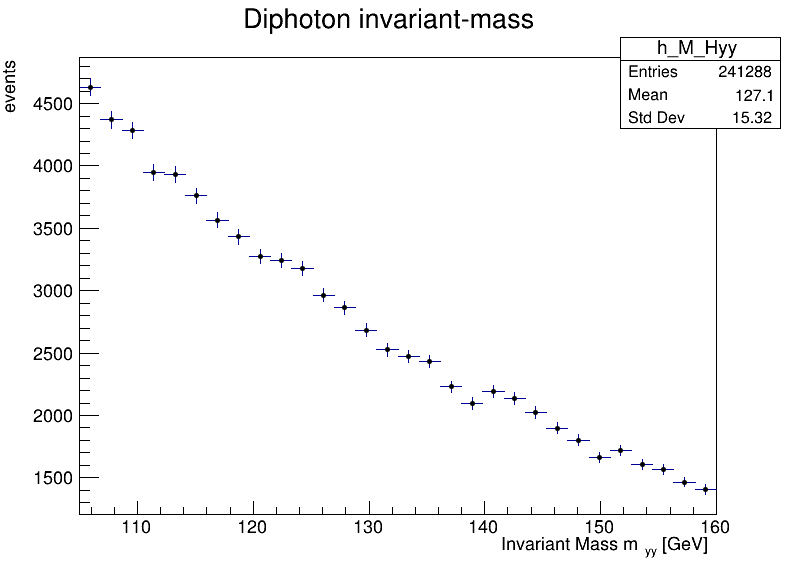

In [64]:
my_hist.SetMarkerStyle(20)
my_hist.SetMarkerSize(0.5)
my_hist.Draw("P")
my_hist.Draw("E")
my_canvas.Draw()

### One more thing we can do!

$H\rightarrow\gamma\gamma$ is a rare event, and its signal can be difficult to see over the background of two photons being produced in other ways (as your plots above show!). One way we can make this easier to see is to make a predicition for what this background looks like.

Here we can do a **data-driven** estimate of the background, by fitting the data with a cubic function, the shape we're assuming for the distribution of background diphoton events.

To do this, we can use ROOT's `.Fit()` function. In the example below, we are passing it two arguments:

- `"pol3"`: Indicates we want to fit out histogram with a third-order polynomial i.e. a cubic function 
- `"S"`: Indictes we will want to draw this function on the same canvas as our histogram

In [65]:
background = my_hist.Fit("pol3",'S')


****************************************
Minimizer is Linear
Chi2                      =      38.2644
NDf                       =           26
p0                        =      34161.4   +/-   6974.72     
p1                        =      -519.06   +/-   158.438     
p2                        =      2.85367   +/-   1.1908      
p3                        =  -0.00556113   +/-   0.00296212  


Now draw our fit on the same plot as our histogram (indicated by the argument `"SAME"`), and redraw our canvas.

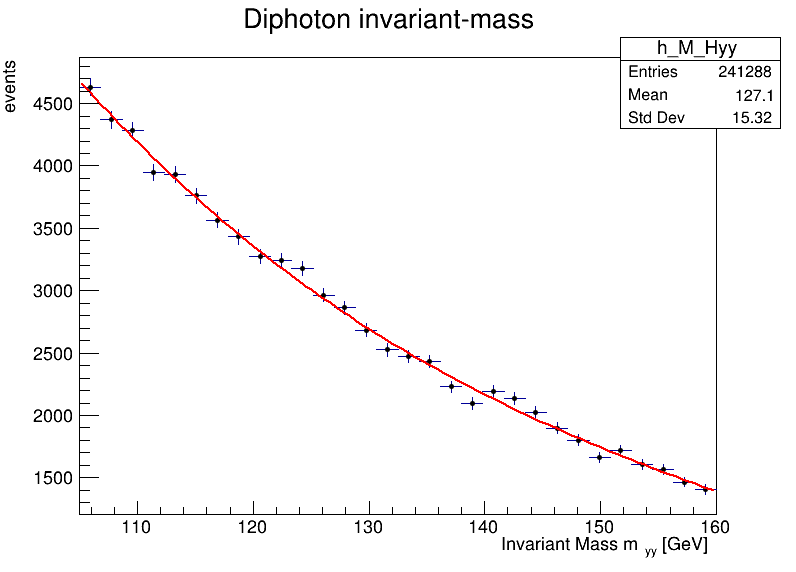

In [66]:
background.Draw("SAME")
my_canvas.Draw()

Is the bump at 125 GeV easier to see now? Compare your plot to the figure from the full ATLAS below, which uses much more data

<CENTER><img src="images/Higgs.png" style="width:50%"></CENTER>

Even with much more data, the bump is small! However, sometimes a small bump is all we need - this amount of extra events over the expected background was enough for the Higgs to be declared discovered in 2012, winning Peter Higgs and François Englert, the scientists who first invented its theory, the Nobel Prize.

---

<CENTER><h2>Search 2: The H&#8594;WW channel</h2></CENTER>

The following analysis will aim to find a signal for the Higgs boson decaying to 2 W-bosons:

<br>

<CENTER><img src="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/HIGG-2016-07/fig_01a.png" style="width:30%"></CENTER>

<br>

above its the largest background; Events coming from the SM WW-diboson background production from two quarks:

<CENTER><img src="https://cds.cern.ch/record/1484203/files/fig1b.png" style="width:30%"></CENTER>


<br>

Unlike the previous analysis, we can't do a bump-hunt when the invariant mass of the decay products are larger than the mass of the particle that's decaying ($m_H$=125 GeV and $m_W$=80 GeV x 2). Instead, we can do a  __non-resonant search__. This is done by histogramming some variable of the decay products (in this case a variable called *transverse mass*) for both data and Monte-Carlo simulations of the background, subtracting the backgrounds from the data (scaled for the fact we have many more simulated events than real events) before looking at the events, if any, left over indicating the presence of the Higgs.

### This analysis is inspired by the prompt on the Open Data website [here](http://opendata.atlas.cern/release/2020/documentation/physics/DL2.html).

#### Before we begin...


Another custom function to simplify our code:

In [3]:
def printTreeBranches(tree):
    """
    A function which makes it simple to peek inside a TTree and see which variables (branches) are available
    
    Parameters
    ----------
    tree : A ROOT TTree
    """
    
    branches = tree.GetListOfBranches()

    print('TTree branch names:')
    print('-------------------')
    for branch in branches:
        print(branch.GetName())

<br>

Now we follow our usual analysis steps...

### 1. Reading in ROOT files

In [4]:
#Dilepton data

#More luminosity is available (B-D)! Add in at some point?
data = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/Data/data_A.2lep.root")
dataTree = data.Get("mini")
print('Tree contains %d entries\n' % dataTree.GetEntries())

#Peek inside?
view_branches = True #Set to True to look inside
if view_branches: printTreeBranches(dataTree)

Tree contains 668152 entries

TTree branch names:
-------------------
runNumber
eventNumber
channelNumber
mcWeight
scaleFactor_PILEUP
scaleFactor_ELE
scaleFactor_MUON
scaleFactor_PHOTON
scaleFactor_TAU
scaleFactor_BTAG
scaleFactor_LepTRIGGER
scaleFactor_PhotonTRIGGER
trigE
trigM
trigP
lep_n
lep_truthMatched
lep_trigMatched
lep_pt
lep_eta
lep_phi
lep_E
lep_z0
lep_charge
lep_type
lep_isTightID
lep_ptcone30
lep_etcone20
lep_trackd0pvunbiased
lep_tracksigd0pvunbiased
met_et
met_phi
jet_n
jet_pt
jet_eta
jet_phi
jet_E
jet_jvt
jet_trueflav
jet_truthMatched
jet_MV2c10
photon_n
photon_truthMatched
photon_trigMatched
photon_pt
photon_eta
photon_phi
photon_E
photon_isTightID
photon_ptcone30
photon_etcone20
photon_convType
tau_n
tau_pt
tau_eta
tau_phi
tau_E
tau_isTightID
tau_truthMatched
tau_trigMatched
tau_nTracks
tau_BDTid
ditau_m
lep_pt_syst
met_et_syst
jet_pt_syst
photon_pt_syst
tau_pt_syst
XSection
SumWeights
largeRjet_n
largeRjet_pt
largeRjet_eta
largeRjet_phi
largeRjet_E
largeRjet_m
largeRj

In [30]:
## qq->WW background (MC)

bkg = ROOT.TFile.Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/MC/mc_363492.llvv.2lep.root")
bkgTree = bkg.Get("mini")
print('Tree contains %d entries\n' % bkgTree.GetEntries()) #Will need to be scaled to number of data events

#Peek inside?
view_branches = False #Set to True to look inside
if view_branches: printTreeBranches(bkgTree)

Tree contains 3409043 entries



### 2. Preparing histograms

In [55]:
c = ROOT.TCanvas("HWWCanvas","Higgs->WW Analysis",800,600)
h_bgs = ROOT.TH1F("h_bgs","Transverse mass mT; Transverse Mass m_{T} [GeV] ; events",20,60,300)
h_dat = ROOT.TH1F("h_dat","Transverse mass mT; Transverse Mass m_{T} [GeV] ; events",20,60,300)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: HWWCanvas
Warning in <TDavixFile::Append>: Replacing existing TH1: h_bgs (Potential memory leak).
Warning in <TDavixFile::Append>: Replacing existing TH1: h_dat (Potential memory leak).


---

### 3. Selecting events and filling histograms

In [56]:
def mcWeights(tree,lumi=10):
    """
    When MC simulation is compared to data the contribution of each simulated event needs to be
    scaled ('reweighted') to account for differences in how some objects behave in simulation
    vs in data, as well as the fact that there are different numbers of events in the MC tree than 
    in the data tree.
    
    Parameters
    ----------
    tree : TTree entry for this event
    """
    
    #These values don't change from event to event
    norm = lumi*(tree.XSection*1000)/tree.SumWeights
    
    #These values do change from event to event
    scale_factors = tree.scaleFactor_ELE*tree.scaleFactor_MUON*tree.scaleFactor_LepTRIGGER*tree.scaleFactor_PILEUP*tree.mcWeight
    
    weight = norm*scale_factors
    return weight

In [57]:
def goodLeptons(tree):
    """
    A function to return the indices of 'good leptons' (electrons or muons) in an event. This follows 
    many of the same steps as locateGoodPhotons() and photonIsolation() above.
    
    Parameters
    ----------
    tree : TTree entry for this event
    """
    
    #Initialise (set up) the variables we want to return
    goodlepton_index = [] #Indices (position in list of event's leptons) of our good leptons
            
    ##Loop through all the leptons in the event
    for j in range(0,tree.lep_n):
            
        ##Check lepton ID
        if(tree.lep_isTightID[j]):
            
            #Check lepton isolation
            #Similar to photonIsolation() above, different thresholds
            if((tree.lep_ptcone30[j]/tree.lep_pt[j] < 0.1) and 
               (tree.lep_etcone20[j]/tree.lep_pt[j] < 0.1)):

                #Only central leptons 
                #Electrons and muons have slightly different eta requirements

                #Electrons: 'Particle type code' = 11
                if tree.lep_type[j] == 11:
                    
                    #Check lepton eta is in the 'central' region and not in "transition region" 
                    if (TMath.Abs(tree.lep_eta[j]) < 2.37) and\
                       (TMath.Abs(tree.lep_eta[j]) < 1.37 or TMath.Abs(tree.lep_eta[j]) > 1.52): 

                        goodlepton_index.append(j) #Store lepton's index

                #Muons: 'Particle type code' = 13
                elif (tree.lep_type[j] == 13) and (TMath.Abs(tree.lep_eta[j]) < 2.5): #Check'central' region

                        goodlepton_index.append(j) #Store lepton's index


    return goodlepton_index #return list of good lepton indices

In [58]:
def hWW(tree,hist,mode):
    """
    Function which executes the analysis flow for the Higgs production cross-section measurement in the H->WW
    decay channel.
    
    Fills a histogram with mT(llvv) of events which pass the full set of cuts 
    
    Parameters
    ----------
    tree : A Ttree containing data / background information
    
    hist : The name of the histogram to be filled with mT(llvv) values
    
    mode : A flag to tell the function if it is looping over 'data' or 'mc'
    """
    
    n = 0
    for event in tree:
        
        #############################
        ### Event-level requirements
        #############################
    
        trackProgress(n,100000)
        n += 1
        
        #If event is MC: Reweight it
        if mode.lower() == 'mc': weight = mcWeights(tree)
        else: weight = 1
            
            
        #If the event passes either the electron or muon trigger
        if tree.trigE or tree.trigM:
            
            ####Lepton preselections
            goodLeps = goodLeptons(tree) #If the datafiles were not already filtered by number of leptons

            ###################################
            ### Individual lepton requirements
            ###################################

            if len(goodLeps) == 2: #Exactly two good leptons...
                lep1 = goodLeps[0] #INDICES of the good leptons
                lep2 = goodLeps[1]

                if tree.lep_type[lep1] != tree.lep_type[lep2]: #... with different flavour

                    if tree.lep_charge[lep1] != tree.lep_charge[lep2]: #... and opposite charge...

                        if (tree.lep_pt[lep1] > 22000) and (tree.lep_pt[lep2] > 15000): #pT requirements
                            #Note: TTrees always sort objects in descending pT order

                            if abs(tree.lep_phi[lep1]-tree.lep_phi[lep2]) < 1.8: #lepton separtion in phi 

                                #################################
                                ### Dilepton system requirements
                                #################################

                                #Initialse (set up) an empty 4 vector for dilepton system
                                dilep_four_mmtm = ROOT.TLorentzVector()

                                #Loop through our list of lepton indices
                                for i in goodLeps:

                                    #Initialse (set up) an empty 4 vector for each lepton
                                    lep_i = ROOT.TLorentzVector()

                                    #Retrieve the lepton's 4 momentum components from the tree
                                    lep_i.SetPtEtaPhiE(tree.lep_pt[i], tree.lep_eta[i],tree.lep_phi[i],tree.lep_E[i])

                                    #Store lepton's 4 momentum
                                    dilep_four_mmtm += lep_i
                                  
                                # Dilepton system pT > 30 GeV
                                if dilep_four_mmtm.Pt() > 30000:

                                    if (dilep_four_mmtm.M() > 10000) and (dilep_four_mmtm.M() < 55000):

                                        #####################
                                        ### MET requirements
                                        #####################

                                        #Initialse (set up) an empty 4 vector for the event's MET and fill from tree
                                        met_four_mom = ROOT.TLorentzVector()
                                        met_four_mom.SetPtEtaPhiE(tree.met_et,0,tree.met_phi,tree.met_et)

                                        #MET > 30 GeV
                                        if met_four_mom.Pt() > 30000:

                                            #Diffence in phi between the dilepton system and the MET < pi/2
                                            if abs(dilep_four_mmtm.Phi()-met_four_mom.Phi()) < 1.571:

                                                #####################
                                                ### Full llvv system
                                                #####################

                                                system_four_mom = dilep_four_mmtm + met_four_mom
                                                
                                                #If Fill() is passed a second argument, the event is weighted by that amount
                                                hist.Fill(system_four_mom.Mt()/1000,weight)
                                        
                                        


#Additional cuts applied by the paper:
#----------------------------------
# Jet cuts!

In [59]:
#Data
hWW(dataTree,h_dat,'data')

Event loop tracker
------------------
0 events processed
100000 events processed
200000 events processed
300000 events processed
400000 events processed
500000 events processed
600000 events processed


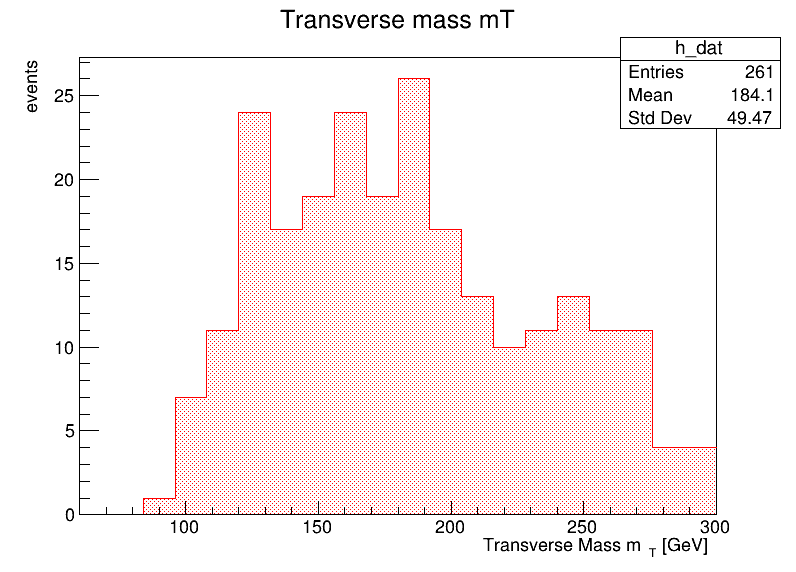

In [60]:
#Look at data histogram

h_dat.SetFillStyle(3003)
h_dat.SetFillColor(2)
h_dat.SetLineColor(2)

h_dat.Draw("hist")
c.Draw()

In [61]:
#MC 
hWW(bkgTree,h_bgs,'mc')

Event loop tracker
------------------
0 events processed
100000 events processed
200000 events processed
300000 events processed
400000 events processed
500000 events processed
600000 events processed
700000 events processed
800000 events processed
900000 events processed
1000000 events processed
1100000 events processed
1200000 events processed
1300000 events processed
1400000 events processed
1500000 events processed
1600000 events processed
1700000 events processed
1800000 events processed
1900000 events processed
2000000 events processed
2100000 events processed
2200000 events processed
2300000 events processed
2400000 events processed
2500000 events processed
2600000 events processed
2700000 events processed
2800000 events processed
2900000 events processed
3000000 events processed
3100000 events processed
3200000 events processed
3300000 events processed
3400000 events processed


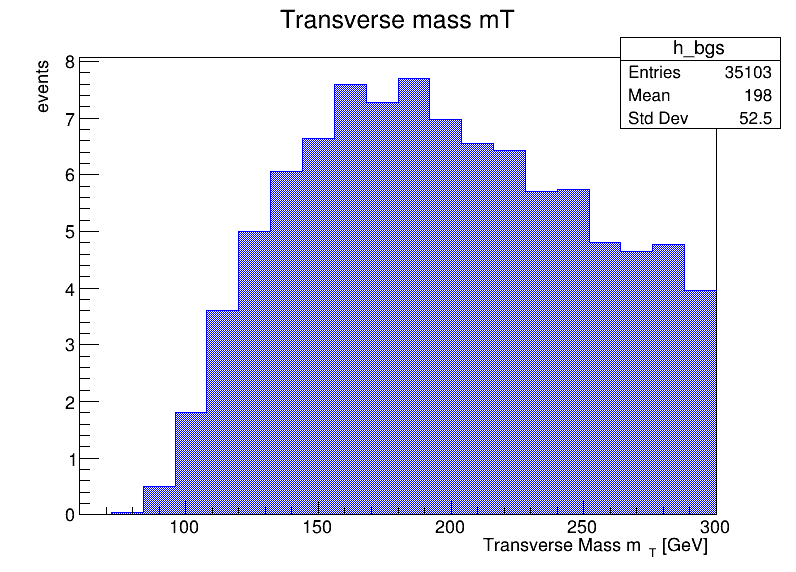

In [62]:
#Look at MC histogram

h_bgs.SetFillStyle(3001)
h_bgs.SetFillColor(4)
h_bgs.SetLineColor(4)

h_bgs.Draw("hist")
c.Draw()

---

### 4. Draw (final) plots

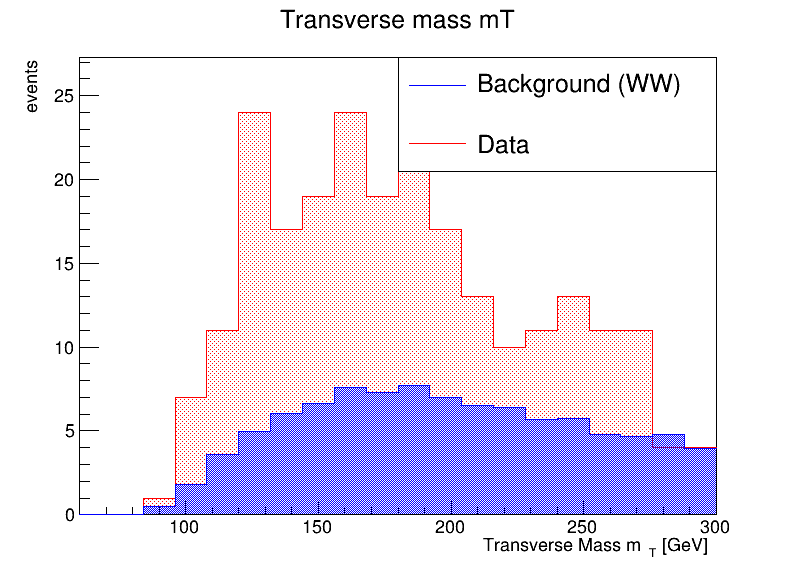

In [63]:
#Draw histograms on same canvas

h_dat.Draw("hist")
h_bgs.Draw("histsame")

h_dat.SetStats(0)
h_bgs.SetStats(0)

legend=ROOT.TLegend(0.5,0.7,0.9,0.9)
legend.AddEntry(h_bgs,"Background (qq->WW) ","l")
legend.AddEntry(h_dat,"Data","l")
legend.Draw()

c.Draw()

In [64]:
#Subtract the two histograms

h_diff = h_dat.Clone("diff")
h_diff.Add(h_bgs,-1)

True

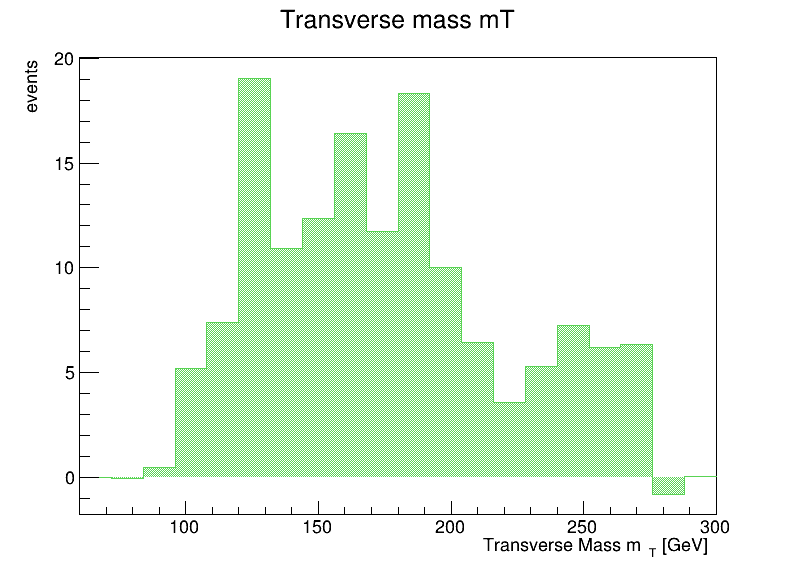

In [65]:
#Plot the subtracted histogram

h_diff.SetFillStyle(3001)
h_diff.SetFillColor(8)
h_diff.SetLineColor(8)
h_diff.SetStats(0)
#h_diff.SetMinimum(10)

h_diff.Draw("hist")
c.Draw()

## Extension exercises

a) This estimation of the strength of our Higgs signal is actually rather overoptimistic! This is because we are only accounting for one background (albeit the strongest one). Another large background to the $H\rightarrow WW$ process comes from top quarks.
- Seach in the [Open Data repository](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020) for some simiulated top quark production data.
- Initialise a histogram for your top data, apply your analysis cuts and fill the histogram
- Think of the best way to display your results on a histogram

<details>
    <summary>Click here for plotting hint 1: </summary>
    Sum your background histograms togther (similar to the subtraction) and adjust your plot legend, or..
</details>

<details>
    <summary>Click here for plotting hint 2: </summary>
    Investigate ROOT's TStack functionality: https://root.cern.ch/doc/master/classTHStack.html
</details>

b) The reason for imposing **cuts** in any analysis is to reduce backgrounds while keeping as many of our signal events as possible. We are now considering a new background, the production of top quarks.

Fortunately, processes involving top quarks are easy to spot, because the decay almost exclusively to **bjets** - showers of strongly interacting particles originating from a bottom quark.

- Take a look at the [prompt](http://opendata.atlas.cern/release/2020/documentation/physics/DL2.html) for this analysis on the Open Data website. You'll notice that there's one about jets that we've skipped.

    - Return to our $H\rightarrow WW$ analysis, and implement this cut to reduced the contribution from our newly-added top background.

<details>
    <summary>Click here for hint 1: </summary>
    Write a function similar to goodLeptons() that returns the indices of good jets in the event. For each jet in an event only keep it if:
        
    jet_pt > 30 GeV
</details>

<details>
    <summary>Click here for hint 2: </summary>
    Write a function similar to goodLeptons() that returns the indices of good bjets in the event. For each bjet in an event only keep it if:
    jet_MV2c10 branch > 0.18    
    jet_pt > 20 GeV
    
- MV2c10 is the ATLAS algorithm that tell's us how likely it is that a jet is a bjet. These kinds of algorithms are called __btaggers__.
</details>

<details>
    <summary>Click here for hint 3: </summary>
    Our btagger is another thing that performs differently on real data vs simulated MC data. This means it needs to be added to the multiplication in our mcWeights() function. 
    
The btagging scale factor changes from event-to-event, and is stored in a branch called `scaleFactor_BTAG`
</details>

<details>
    <summary>Click here for hint 4: </summary>
    
In our main event loop, only keep an event if it has:
    - Less than 2 good-jets
    - 0 good-bjets 
        
</details>

---

### The two analyses presented in this notebooks are inspired by the [prompts](http://opendata.atlas.cern/release/2020/documentation/physics/intro.html) on the ATLAS Open Data website. 
- This is a great place to start for ideas for your own research - Good luck!!

---